# Introduction

This analysis is focused on 1) quantifying the potential susceptibility individuals with the single nucleotide polymorphism (SNP) rs11191439 (in As3MT) have with respect to inorganic arsenic exposure, 2) performing a geographic analysis with respect to where these individuals may reside, and 3) identifying potential geographic regions that may be at enhanced risk.

# Demographic Data

The US Cenus Bureau's American FactFinder was used to obtain the 5-year estimates for the 2010-2014 American Community Survey. This survey is a random sample that provides estimates of ethnicities and races throughout the United States. Our data is based on zipcodes (https://factfinder.census.gov/faces/nav/jsf/pages/index.xhtml). 

# rs11191439 Frequency Data

We obtained race/ethnicity frequencies for the SNP rs11191439 from the 1,000 Genomes Browser (http://www.ncbi.nlm.nih.gov/variation/tools/1000genomes/?q=rs11191439). 

# Bladder Cancer Odds Ratios and Probabilities for rs11191439 and Arsenic Exposure

The bladder cancer odds ratios and probabilities for rs11191439 and arsenic exposure were obtained from Beebe-Dimmer, et al (http://ehjournal.biomedcentral.com/articles/10.1186/1476-069X-11-43). 

# Groundwater Arsenic Concentrations

The groundwater arsenic concentrations were obtained from the United States Geological Survey (USGS; http://water.usgs.gov/nawqa/trace/pubs/geo_v46n11/). The latest data were released in 2000, and contain over 30,000 records. 

# Analysis

The analysis starts by loading all of the required libraries. Next, the census data is read in.

In [1]:
library(zipcode)
library(ggmap)
library(ggplot2)
library(tidyr)
library(rgeos)
library(sp)
library(parallel)

#Read in the Census data
setwd("../../census_data/ACS_14_5YR_DP05")
us_census_race_ethnicity_data <- read.csv("ACS_14_5YR_DP05.csv", header=TRUE, skip=1,
                                          check.names = FALSE)
setwd("../../gis_analysis/gis_analysis")

Loading required package: ggplot2
Warning message:
: package ‘rgeos’ was built under R version 3.2.5rgeos version: 0.3-19, (SVN revision 524)
 GEOS runtime version: 3.4.2-CAPI-1.8.2 r3921 
 Linking to sp version: 1.1-1 
 Polygon checking: TRUE 

Warning message:
: package ‘sp’ was built under R version 3.2.5

The data are grouped by zipcode; however, they need to be converted to latitude and longitude (geocoordinates).

In [2]:
data("zipcode")
us_census_race_ethnicity_data$Zip <- clean.zipcodes(us_census_race_ethnicity_data$Id2)
us_census_race_ethnicity_data <- merge(us_census_race_ethnicity_data, zipcode, by.x="Zip", by.y = "zip")

Warning message:
In merge.data.frame(us_census_race_ethnicity_data, zipcode, by.x = "Zip", : column names ‘Estimate; SEX AND AGE - 18 years and over’, ‘Margin of Error; SEX AND AGE - 18 years and over’, ‘Percent; SEX AND AGE - 18 years and over’, ‘Percent Margin of Error; SEX AND AGE - 18 years and over’, ‘Estimate; SEX AND AGE - 65 years and over’, ‘Margin of Error; SEX AND AGE - 65 years and over’, ‘Percent; SEX AND AGE - 65 years and over’, ‘Percent Margin of Error; SEX AND AGE - 65 years and over’ are duplicated in the result

I'm not worried about the warning message here. That won't cause a problem for our downstream analyses.

Next, the data are going to be paired down to only those columns that we need for the rest of the analysis.

In [3]:
estimate_columns <- c("Estimate; HISPANIC OR LATINO AND RACE - Total population - Hispanic or Latino (of any race) - Mexican",
                      "Estimate; HISPANIC OR LATINO AND RACE - Total population - Hispanic or Latino (of any race) - Puerto Rican",
                      "Estimate; HISPANIC OR LATINO AND RACE - Total population - Hispanic or Latino (of any race) - Cuban",
                      "Estimate; HISPANIC OR LATINO AND RACE - Total population - Hispanic or Latino (of any race) - Other Hispanic or Latino",
                      "Estimate; HISPANIC OR LATINO AND RACE - Total population - Not Hispanic or Latino - White alone",
                      "Estimate; HISPANIC OR LATINO AND RACE - Total population - Not Hispanic or Latino - Black or African American alone",
                      "Estimate; HISPANIC OR LATINO AND RACE - Total population - Not Hispanic or Latino - American Indian and Alaska Native alone",
                      "Estimate; HISPANIC OR LATINO AND RACE - Total population - Not Hispanic or Latino - Asian alone",
                      "Estimate; HISPANIC OR LATINO AND RACE - Total population - Not Hispanic or Latino - Native Hawaiian and Other Pacific Islander alone",
                      "Estimate; HISPANIC OR LATINO AND RACE - Total population - Not Hispanic or Latino - Some other race alone",
                      "Estimate; HISPANIC OR LATINO AND RACE - Total population - Not Hispanic or Latino - Two or more races")
all_necessary_columns <- c(estimate_columns, "latitude", "longitude")
us_census_race_ethnicity_data_trimmed <- us_census_race_ethnicity_data[, which(colnames(us_census_race_ethnicity_data) %in% all_necessary_columns)]


Next, the genotype information is read in.

In [4]:
genotype_frequencies <- read.table("rs11191439.txt", sep="\t", header=TRUE)
weighted_avg_genome_freqs <- by(genotype_frequencies, genotype_frequencies$Larger.Group, function(x) weighted.mean(x$C_Freq, x$Count), simplify=FALSE)
global_average <- weighted.mean(genotype_frequencies$C_Freq, genotype_frequencies$Count)

#Now I need to put these genotype frequencies into the right order, and use the global average when we have no other information
genotype_ordered <- c(weighted_avg_genome_freqs$Mexican, 
                      weighted_avg_genome_freqs$`Puerto Rican`,
                      global_average,
                      global_average,
                      weighted_avg_genome_freqs$White,
                      weighted_avg_genome_freqs$African,
                      global_average,
                      weighted_avg_genome_freqs$Asian,
                      global_average,
                      global_average,
                      global_average)

Following is a table of the allele frequencies for various ethnic/racial groups. The T allele is the major/predominant and ancestoral allele, while the C allele is the mutant polymorphism.

In [12]:
genotype_frequencies[, c(1, 4,5)]

Group..Descent.    T_Freq     C_Freq
1        African Carribbeans 0.9218750 0.07812500
2          African Americans 0.8688525 0.13114754
3   Bengali from Bangaladesh 0.9593023 0.04069767
4               Chinease Dai 0.9838710 0.01612903
5               Caucasian US 0.9040404 0.09595960
6                Han Chinese 0.9805825 0.01941748
7                Han Chinese 0.9761905 0.02380952
8            Esan in Nigeria 0.9141414 0.08585859
9         Finnish in Finland 0.9090909 0.09090909
10        British in England 0.8626374 0.13736264
11           Gujarati Indian 0.9320388 0.06796117
12                   Gambian 0.8672566 0.13274336
13          Iberian in Spain 0.8831776 0.11682243
14             Indian Telugu 0.9558824 0.04411765
15                  Japanese 0.9759615 0.02403846
16       Kinh in Ho Chi Minh 0.9747475 0.02525253
17            Luhya in Kenya 0.9343434 0.06565657
18     Mende in Sierra Leone 0.9117647 0.08823529
19                   Mexican 0.9296875 0.07031250
20                  Peruvian 0.9529412 0.04705882
21                   Punjabi 0.9322917 0.06770833
22              Puerto Rican 0.8221154 0.17788461
23                Sri Lankan 0.9362745 0.06372549
24                   Toscani 0.8738318 0.12616822
25 Yoruba in Ibadan, Nigeria 0.9166667 0.08333333

The census and genotype information are combined next.

In [7]:
prod_fun <- function(x, y){
  x * y
}

t_census_genotype_freqs <- apply(as.matrix(us_census_race_ethnicity_data_trimmed[, 1:11]), 
                               1, 
                               prod_fun, 
                               y=t(as.matrix(genotype_ordered)))

#Want to keep this so that the rows are the zip codes
census_genotype_freqs <- t(t_census_genotype_freqs)

#Aggregate the number of genetically susceptible people by zipcode
agg_census_genotype_by_latlong <- rowSums(census_genotype_freqs)

#Aggregate the population for each zipcode
agg_census_total_population_by_latlong <- rowSums(as.matrix(us_census_race_ethnicity_data_trimmed[, 1:11]))

#Add back in the geocoordinates
agg_census_genotype_by_latlong <- cbind(susc_individuals = agg_census_genotype_by_latlong, 
                                        latitude = us_census_race_ethnicity_data_trimmed$latitude,
                                        longitude = us_census_race_ethnicity_data_trimmed$longitude)

agg_census_total_population_by_latlong <- cbind(population = agg_census_total_population_by_latlong, 
                                        latitude = us_census_race_ethnicity_data_trimmed$latitude,
                                        longitude = us_census_race_ethnicity_data_trimmed$longitude)

prop_at_risk_census_by_latlong <- data.frame(agg_census_genotype_by_latlong)$susc_individuals / data.frame(agg_census_total_population_by_latlong)$population

prop_at_risk_census_by_latlong <- cbind(proportion = prop_at_risk_census_by_latlong,
                                        latitude = us_census_race_ethnicity_data_trimmed$latitude,
                                        longitude = us_census_race_ethnicity_data_trimmed$longitude)

prop_at_risk_census_by_latlong <- as.data.frame(prop_at_risk_census_by_latlong)

Next, the system will request a map of the US from Google.

In [8]:
us_map <- get_map("united states", zoom=4)

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=united+states&zoom=4&size=640x640&scale=2&maptype=terrain&language=en-EN&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=united%20states&sensor=false


There are a lot of zipcodes that likely have very few susceptible individuals. These zipcodes begin to obscure the map, and make it harder to visualize. Thus, all zipcodes with fewer than 5,000 susceptible individuals are not going to be part of this analysis.

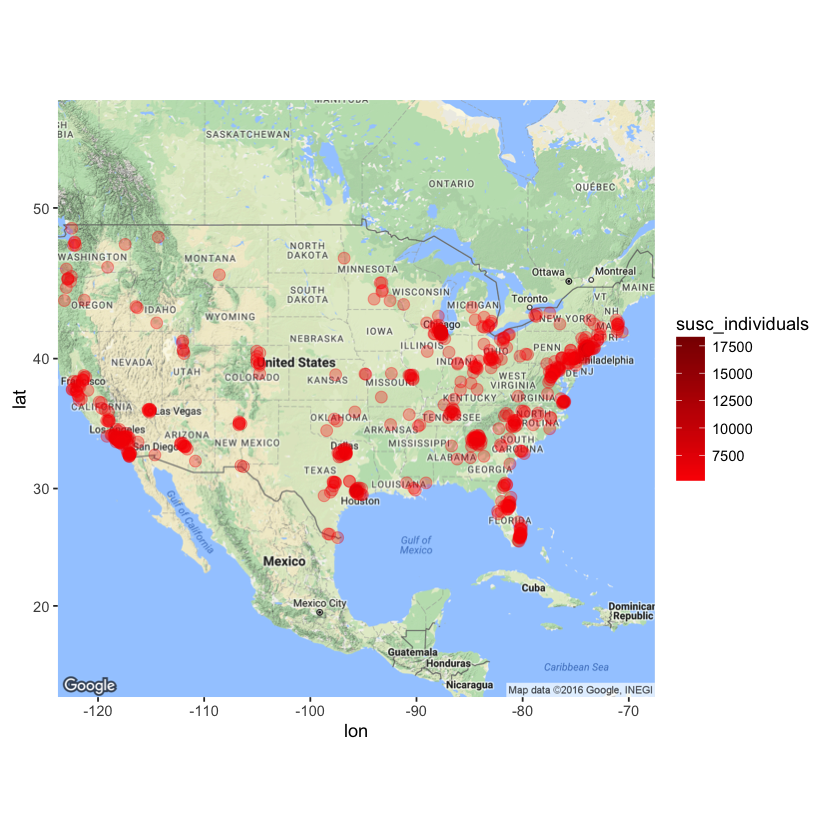

In [31]:
agg_census_genotype_by_latlong <- as.data.frame(agg_census_genotype_by_latlong)
agg_census_genotype_by_latlong_threshold <- agg_census_genotype_by_latlong[which(agg_census_genotype_by_latlong$susc_individuals > 5000), ]
ggmap(us_map) + geom_point(
  aes(x=longitude, y=latitude, show_guide = TRUE, colour=susc_individuals), 
  data=agg_census_genotype_by_latlong_threshold, alpha=.30, na.rm = T, size=3)  + 
  scale_color_gradient(low="red", high="dark red")

Unsurprisingly, the largest groups of susceptible individuals will reside in larger metropolitan areas, where the populations are higher. 

Next, the USGS arsenic groundwater data are loaded up. These data are then related to the nearest geocoordinate from the Census data.

In [11]:
usgs_arsenic_data <- read.table("arsenic_nov2001_usgs.txt", sep="\t", header=TRUE)
usgs_arsenic_data <- usgs_arsenic_data[, c(10:12)]
colnames(usgs_arsenic_data) <- c("concentration", "latitude", "longitude")
usgs_arsenic_data$longitude <- -1 * usgs_arsenic_data$longitude
usgs_geospatial_odds_ratio <- usgs_arsenic_data$concentration * 1.7
usgs_geospatial_odds_ratio <- cbind(odds_ratio = usgs_geospatial_odds_ratio, 
                                    latitude = usgs_arsenic_data$latitude,
                                    longitude = usgs_arsenic_data$longitude)

usgs_geospatial_odds_ratio <- as.data.frame(usgs_geospatial_odds_ratio)

usgs_latlong <- usgs_geospatial_odds_ratio[, 2:3]
census_latlong <- prop_at_risk_census_by_latlong[, 2:3]

#set1sp <- SpatialPoints(usgs_latlong)
#set2sp <- SpatialPoints(census_latlong)



#This next step takes a LONG time to run
#set1$nearest_in_set2 <- apply(gDistance(set1sp, set2sp, byid=TRUE), 1, which.min)


library(geosphere)

# create distance matrix
mat <- distm(usgs_geospatial_odds_ratio[,c("longitude", "latitude")], census_latlong[,c("longitude", "latitude")], fun=distCosine)


# assign the name to the point in list1 based on shortest distance in the matrix
#list1$locality <- list2$locality[apply(mat, 1, which.min)]
no_cores <- detectCores() - 1
cl <- makeCluster(no_cores)
mat_min_row <- parRapply(cl, mat, which.min)
stopCluster(cl)

usgs_x_census_latitude <- census_latlong$latitude[mat_min_row]
usgs_x_census_longitude <- census_latlong$longitude[mat_min_row]
usgs_prop_at_risk <- prop_at_risk_census_by_latlong$proportion[mat_min_row]


Warning message:
: package ‘geosphere’ was built under R version 3.2.5

Odds ratios are values that show how many more cases of bladder cancer would be expected in populations with the minor allele vs the major allele. 

The population attributable risk (PAR) is the amount of risk or number of cases that would not exist if the arsenic exposure and minor allele did not occur. Another way to think of it is that the PAR is the number of cases that exist due to the arsenic exposure and the minor allele. 

The odds ratios are converted to relative risk using:

Relative Risk=Odds Ratio/((1–p0)+(p0∗Odds Ratio))

The PAR is calculated as:

PAR = Pe*(RRe-1)/([1 + Pe*(RRe-1)])

where Pe is the proportion of the population at risk, and RRe is the relative risk for the population at risk. 

In [17]:
p0 <- 0.437 #from Beebe-Dimmer, et al
usgs_geospatial_rr <- (usgs_geospatial_odds_ratio$odds_ratio) / ((1-p0)+(p0*usgs_geospatial_odds_ratio$odds_ratio))
usgs_geospatial_par <- (usgs_prop_at_risk * (usgs_geospatial_rr-1))/(1 + usgs_prop_at_risk * (usgs_geospatial_rr - 1))
usgs_geospatial_par_latlong <- cbind(par = usgs_geospatial_par,
                                     latitude = usgs_x_census_latitude,
                                     longitude = usgs_x_census_longitude)
usgs_geospatial_par_latlong <- as.data.frame(usgs_geospatial_par_latlong)
usgs_geospatial_par_incidence_latlong <- cbind(par_incidence = usgs_geospatial_par_latlong$par * data.frame(agg_census_total_population_by_latlong)$population[mat_min_row],
                                               latitude = usgs_x_census_latitude,
                                               longitude = usgs_x_census_longitude)


One of the questions of interest includes where the PAR is the highest. 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
: Removed 80 rows containing non-finite values (stat_bin).

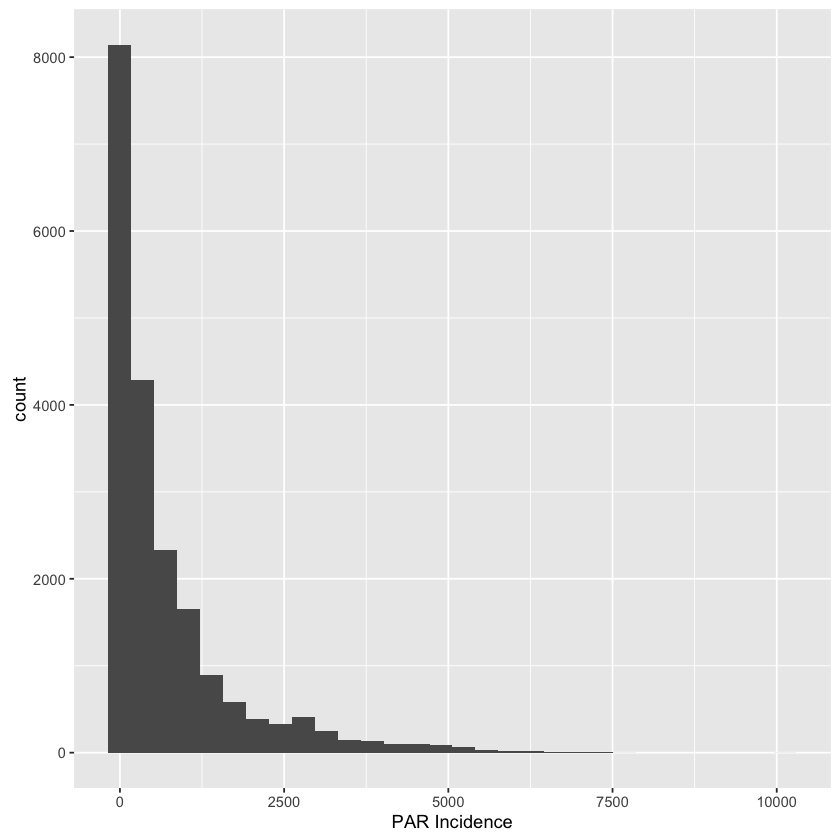

In [38]:
qplot(as.data.frame(usgs_geospatial_par_incidence_latlong)$par_incidence, geom="histogram", xlab="PAR Incidence")
cutoff <- quantile(as.data.frame(usgs_geospatial_par_incidence_latlong)$par_incidence, probs=0.75, na.rm = TRUE)
usgs_geospatial_par_incidence_latlong <- as.data.frame(usgs_geospatial_par_incidence_latlong)
usgs_geospatial_par_incidence_latlong_threshold <- usgs_geospatial_par_incidence_latlong[which(usgs_geospatial_par_incidence_latlong$par_incidence >= cutoff), ]


Clearly, most of the PAR is on the lower end. For visualization purposes, we will consider the largest 25% of the PAR distribution.

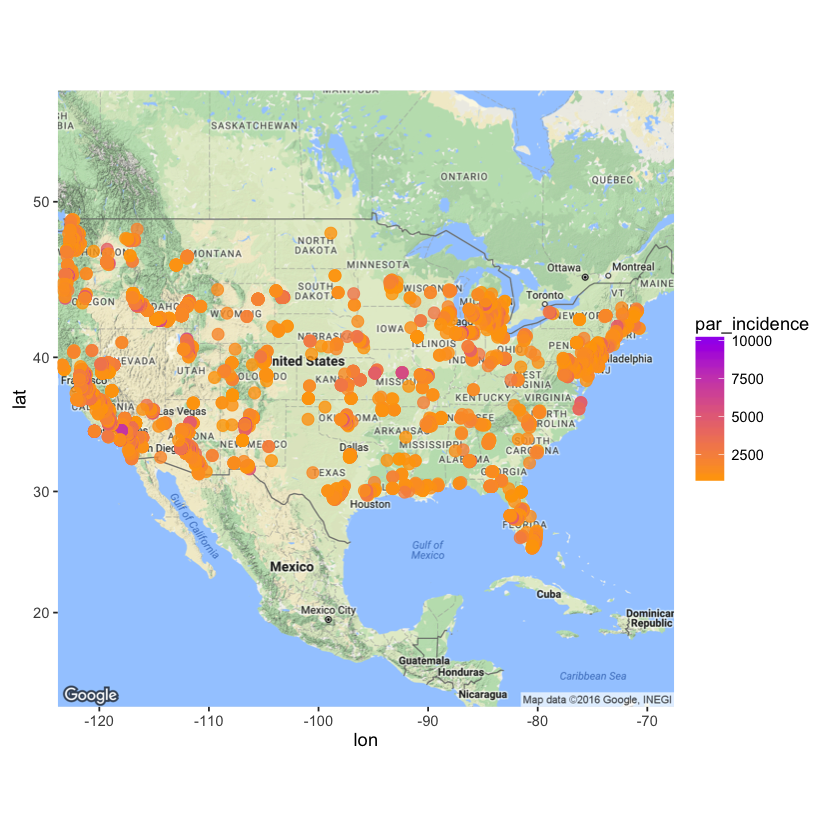

In [36]:
ggmap(us_map) + geom_point(
  aes(x=longitude, y=latitude, show_guide = TRUE, colour=par_incidence), 
  data=usgs_geospatial_par_incidence_latlong_threshold, alpha=0.8, na.rm = T, size=3)  + 
  scale_color_gradient(low="orange", high="purple")

The map above represents the locales with the 25% largest PAR values. Note that the PAR takes into account the local arsenic groundwater concentrations and the number of susceptible people. Note that there are no arsenic groundwater measurements for Puerto Rico.

The posterior probability of someone with the rs11191439 SNP developing bladder cancer when exposed to 3.72ug/L or more arsenic is dependent upon: the underlying probability of someone developing bladder cancer in the US (the prior probability; 20.1/100,000 people; http://seer.cancer.gov/statfacts/html/urinb.html on August 29, 2016), and the probability of arsenic exposures above 3.72ug/L leading to bladder cancer (http://ehjournal.biomedcentral.com/articles/10.1186/1476-069X-11-43).

In [24]:
prior_prob_bladder_cancer <- 20.1/100000 #http://seer.cancer.gov/statfacts/html/urinb.html on August 29, 2016
p_arsenic_given_bladder_cancer <- 0.70  #http://ehjournal.biomedcentral.com/articles/10.1186/1476-069X-11-43
denominator <- (prior_prob_bladder_cancer * p_arsenic_given_bladder_cancer) + (0.30 * (1 - prior_prob_bladder_cancer))
posterior_bladder_cancer_given_arsenic_snp <- (prior_prob_bladder_cancer * p_arsenic_given_bladder_cancer) / denominator
posterior_bladder_cancer_given_arsenic_snp * 100000 #incidence per 100,000 people

[1] 46.88743

The posterior probability of someone with the rs11191439 SNP, who is also exposed to 3.72ug/L or more arsenic is 46.9 per 100,000 people. 

This is compared to the posterior probability of someone who is carrying the ancestral/major allele:

In [25]:
prior_prob_bladder_cancer <- 20.1/100000 #http://seer.cancer.gov/statfacts/html/urinb.html on August 29, 2016
p_arsenic_given_bladder_cancer <- 41/102  #http://ehjournal.biomedcentral.com/articles/10.1186/1476-069X-11-43
denominator <- (prior_prob_bladder_cancer * p_arsenic_given_bladder_cancer) + (.598 * (1 - prior_prob_bladder_cancer))
posterior_bladder_cancer_given_arsenic_no_snp <- (prior_prob_bladder_cancer * p_arsenic_given_bladder_cancer) / denominator
posterior_bladder_cancer_given_arsenic_no_snp * 100000 #incidence per 100,000 people

[1] 13.51161

The posterior probability of someone with the major allele, who is also exposed to 3.72ug/L or more arsenic is 13.5 per 100,000 people.

In [26]:
(posterior_bladder_cancer_given_arsenic_snp/(1-posterior_bladder_cancer_given_arsenic_snp))/(posterior_bladder_cancer_given_arsenic_no_snp/(1-posterior_bladder_cancer_given_arsenic_no_snp))

[1] 3.471317

The posterior odds ratio is 3.47:1. This means that those with the rs11191439 SNP who are also exposed to 3.72ug/L or more arsenic are 3.47x more likely to develop bladder cancer than those with the ancestral/major allele. This suggests that a data-driven human variability uncertainty factor of 3.47 would be protective for this particular sensitive population. This suggests that an uncertainty factor of 3 would not be sufficient to protect this population.

In [30]:
rs11191439_pop <- sum(agg_census_genotype_by_latlong[,1]) / sum(agg_census_total_population_by_latlong[,1])
rs11191439_pop
rs11191439_us <- 324355333 * rs11191439_pop #estimated US population: 29 August 2016 http://www.census.gov/popclock/
rs11191439_us

new_bladder_cancer_cases <- rs11191439_us * 46.9/100000
new_bladder_cancer_cases


[1] 0.1016972

[1] 32986015

[1] 15470.44

The proportion of the population that is susceptible due to rs11191439 is estimated at 10.2%. The size of the US population estimated to be susceptible to bladder cancer due to rs1191439 is 32,986,015. 

# Conclusions

The posterior probability of someone with the rs11191439 risk allele developing bladder cancer when exposed to 3.72ug/L or more arsenic is 46.9 per 100,000 people. Given the estimated number of susceptible individuals in the US population, if these individuals were exposed to 3.72ug/L or more arsenic through their drinking water, one would anticipate 15,470 new cases of bladder cancer each year in the US population, due just to ingesting this amount of arsenic.